In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [13]:
%%time

num_snapshots = 100#0
n_p = 15
n_b = 200
l_0 = .1 #(length_kuhn = 10)
l_p = 1
kappa = l_p/l_0
all_snaps = np.zeros(num_snapshots, dtype=object)
for snap in range(num_snapshots):
    output = np.zeros([n_p*n_b, 3])

    for poly in range(n_p):
        #first bead
        r1 = np.array([0, 0, 0])
        output[poly*n_b] = r1
        
        phi = 2*np.pi*random.uniform(0, 1)
        theta = np.arccos(random.uniform(-1, 1))
        u_2 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        r2 = u_2 * l_0
        output[poly*n_b + 1] = r2

        prev_r = r2
        for bead in range(n_b-2):
            r = random.uniform(0, 1)
            rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
            theta = np.arccos(rho)
            phi = 2*np.pi*random.uniform(0, 1)

            #define z' as previous r
            z_prime = output[poly*n_b + bead + 1]
            z_prime = z_prime / np.linalg.norm(z_prime)
            
            
#             #PATH A: rotation matrix

#             #define x' and y' using rotation matrix wrt phi about z axis (random phi angle)
            
#             rot_mat = np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]])
#             x_prime = np.array([1, 2, 3], dtype = 'float64')
#             x_prime -= np.dot(x_prime, z_prime) * z_prime      # make it orthogonal to z_prime
#             x_prime /= np.linalg.norm(x_prime)

#             y_prime = np.cross(z_prime, x_prime)
            
#             #calculate new r_prime in x'y'z' axes

#             r_prime = np.array([l_0 * np.sin(theta), 0, l_0 * np.cos(theta)])

#             #covert r_prime from x'y'z' to xyz

#             axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
#             origin_1 = np.array([0, 0, 0])

#             axes_2 = np.dot(rot_mat, np.array([x_prime, y_prime, z_prime]))
#             origin_2 = output[poly*n_b + bead + 1]

#             r_bead = np.dot(np.transpose(axes_1), (origin_2 - origin_1 + np.dot(axes_2, r_prime)))
            
            
            #PATH B: random x_prime; doesnt work?
            #THIS MAY BE THE ISSUE -> random x vector does not ensure random phi!!
            x_prime = np.random.randn(3)  # take a random vector (phi = random angle)
            x_prime -= np.dot(x_prime, z_prime) * z_prime      # make it orthogonal to z_prime
            x_prime /= np.linalg.norm(x_prime)

            y_prime = np.cross(z_prime, x_prime)

            #calculate new r_prime in x'y'z' axes

            r_prime = np.array([l_0 * np.sin(theta), 0, l_0 * np.cos(theta)])

            #covert r_prime from x'y'z' to xyz

            axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
            origin_1 = np.array([0, 0, 0])

            axes_2 = np.array([x_prime, y_prime, z_prime])
            origin_2 = output[poly*n_b + bead + 1]

            r_bead = np.dot(np.transpose(axes_1), (origin_2 - origin_1 + np.dot(axes_2, r_prime)))


            #u_bead = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
            #r_bead = u_bead * l_0
            #print(r_bead)
            #output[poly*n_b + bead + 2] = output[poly*n_b + bead + 1] + r_bead #how to find next x y z coordinates
            output[poly*n_b + bead + 2] = r_bead
    all_snaps[snap] = output

Wall time: 44.4 s


In [3]:
# fig = plt.figure()
# rng1 = 0
# rng2 = 5
# ax = plt.axes(projection='3d')
# ax.scatter3D(otpt[rng1:rng2, 0], otpt[rng1:rng2, 1], otpt[rng1:rng2, 2] ,color='y')

In [4]:
import sys
sys.path.insert(1, '../wlcstat/')

In [5]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import wlcstat.wlcave as wlcave
import wlcstat.wlcgreen as wlcgreen
import wlcstat.wlcstruc as wlcstruc
import wlcstat.poly_dyn as poly_dyn
import wlcstat.wlc_lcpoly as wlc_lcpoly
import wlcstat.poly_confine as poly_confine
import wlcstat.active_brown as active_brown
import wlcstat.util.wlc_vertex as vertex
import importlib

In [6]:
import importlib
importlib.reload(wlcave)
importlib.reload(wlcgreen)
importlib.reload(wlcstruc)
importlib.reload(poly_dyn)
importlib.reload(poly_confine)
importlib.reload(wlc_lcpoly)
importlib.reload(active_brown)

<module 'wlcstat.active_brown' from 'C:\\Users\\Thomas\\Desktop\\structure_factor\\structure_factor\\wlcstat\\active_brown.py'>

In [7]:
n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10
i_snap_0 = 9000
i_snap_f = 10000

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

s2_sim = np.zeros(nk)

for i_snap in range(i_snap_0, i_snap_f + 1):
    u_snap = np.loadtxt('sim_data/u' + str(i_snap))
    r_snap = np.loadtxt('sim_data/r' + str(i_snap))
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :]
        
        #why can you separate by x, y, z?
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,0]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,1]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,2]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)

In [14]:
i_snap_f = num_snapshots-1
i_snap_0 = 0

s2_sim_cga = np.zeros(nk)
for i_snap in range(num_snapshots):
    r_snap = all_snaps[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :]

        #why can you separate by x, y, z?
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,0]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,1]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,2]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)

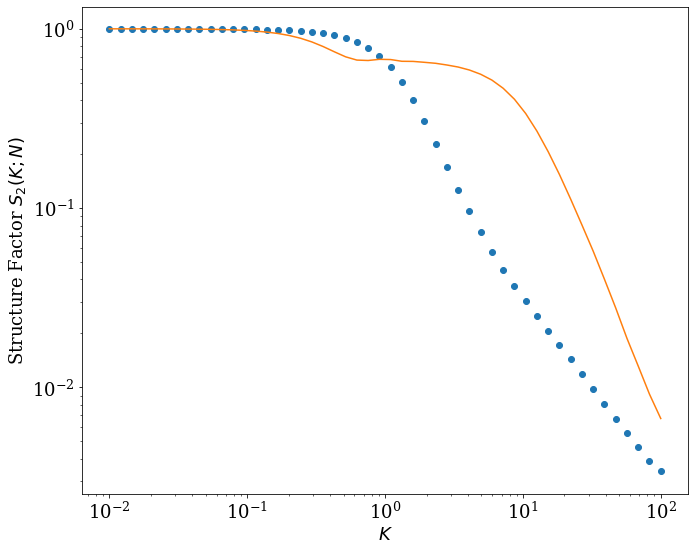

In [15]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, s2_sim,'o')
plt.plot(k_vec, s2_sim_cga)
#plt.plot(k_vec, 1-s2_th,'-')    
#plt.plot(k_vec, 1-s2_asymp,'--')    

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.show()